<a href="https://colab.research.google.com/github/ilham-mukti/Machine-Learning/blob/main/Nyoba_3_2_XGBoost_Regresi_(Plot_Residual).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopml

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

from skopt import BayesSearchCV
from xgboost import XGBRegressor, XGBClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix, plot_actual_vs_prediction, plot_residual
from jcopml.tuning.space import Integer, Real

sns.set()

In [43]:
datas = pd.read_csv("/content/taxi_fare.csv", parse_dates=['pickup_datetime'])
datas.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [44]:
datas.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64

In [45]:
datas.dropna(inplace=True)

In [46]:
pickup_dt = datas.pickup_datetime.dt

In [47]:
datas['year'] = pickup_dt.year
datas['month'] = pickup_dt.month
datas['day'] = pickup_dt.dayofweek
datas['hour'] = pickup_dt.hour
datas.drop(columns='pickup_datetime', inplace=True)

In [48]:
datas['distance'] = np.abs(datas.pickup_longitude - datas.dropoff_longitude) + np.abs(datas.pickup_latitude - datas.dropoff_latitude)
datas.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)

In [49]:
datas.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [50]:
datas = datas[(datas.distance > 0) & (datas.fare_amount > 0)]

In [51]:
X = datas.drop(columns='fare_amount')
y = datas.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((14705, 6), (3677, 6))

In [36]:
rsp.xgb_poly_params

{'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__max_depth': Integer(low=1, high=10),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False]}

In [37]:
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['month', 'day', 'hour']),
    ('numeric', num_pipe(), ['year', 'distance', 'passenger_count'])
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])  

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


[10:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('prep',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('categoric',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                       

In [38]:
model.best_params_, model.score(X_train, y_train), model.score(X_test, y_test)

({'algo__colsample_bytree': 0.6024641082463879,
  'algo__gamma': 7,
  'algo__learning_rate': 0.04764963542138517,
  'algo__max_depth': 3,
  'algo__n_estimators': 118,
  'algo__reg_alpha': 0.8013508750140631,
  'algo__reg_lambda': 3.8765111709116367,
  'algo__subsample': 0.7435432121325587},
 0.8033380974024986,
 0.7920985966296915)

# Feature Importance

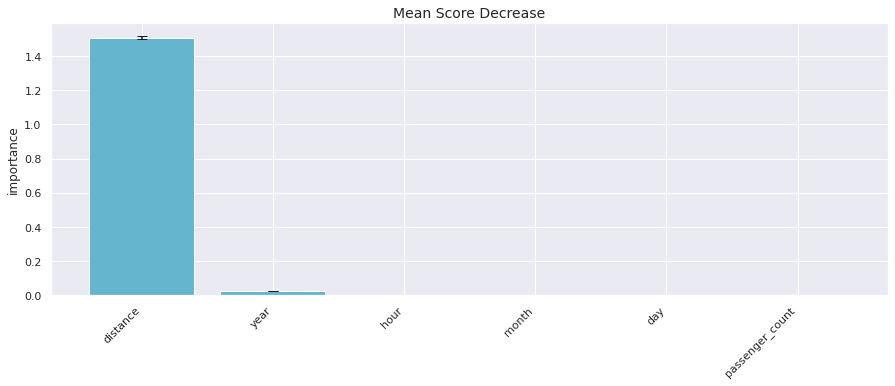

In [41]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Evaluation: Plot

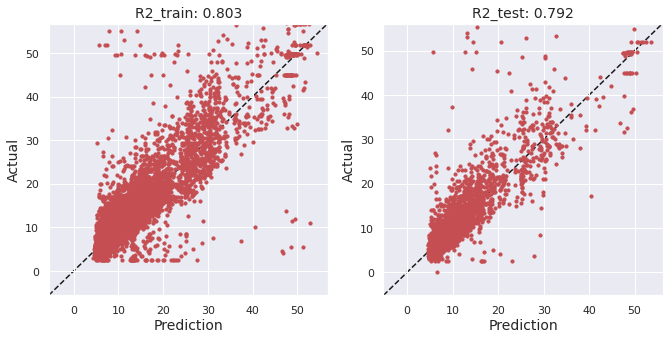

In [39]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


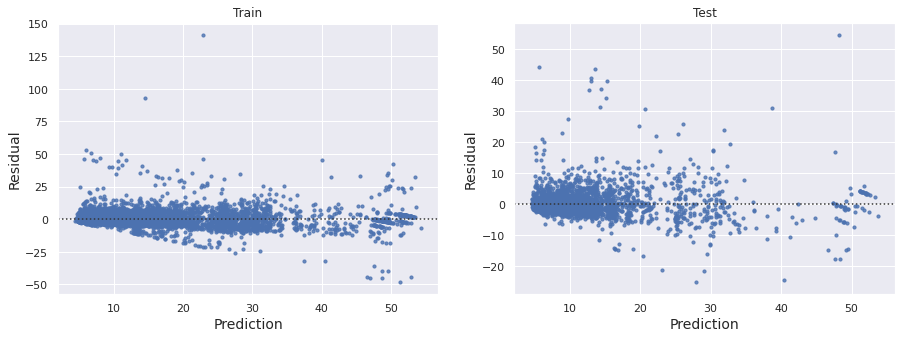

In [40]:
plot_residual(X_train, y_train, X_test, y_test, model)

# Evaluation: Setelah diplot residual, Cari Data yang Errornya paling besar

In [42]:
datas_analisis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

datas_analisis['fare'] = y_train
datas_analisis['error'] = error
datas_analisis.sort_values('error', ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1483,1.0,2009,8,4,21,0.000416,165.00,142.087732
14142,1.0,2014,12,4,10,0.045860,108.00,93.575036
2432,1.0,2012,11,4,1,0.003817,58.60,52.699322
5970,1.0,2014,3,3,18,0.003541,57.33,50.639532
18807,2.0,2013,8,5,2,0.038527,61.25,50.215394
1494,1.0,2009,9,1,14,0.000031,70.00,47.165365
13280,1.0,2009,6,0,21,0.029244,55.00,47.016864
12614,2.0,2011,8,4,7,0.215239,87.00,46.978455
5078,5.0,2013,1,1,13,0.006011,52.00,46.277633
676,1.0,2013,4,4,19,0.289328,5.50,45.873226


# Correlation Matrix

In [53]:
plot_correlation_matrix(datas, 'fare_amount', numeric_col=['passenger_count', 'year', 'distance'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…